# Model Performance Issues 

### Performance of the Chair Model vs. Heel Model

When comparing the two models via k-Fold Cross Validation, the Chair Exercise model (`final_chair_model.h5`) showed an average training MAE of **≈19.06** points, whereas the Heel Exercise model (`final_heel_model.h5`) achieved **≈10.68** points. Despite using the same pipeline—feature extraction, sequence reshaping, model architecture, and training procedure—the Chair model failed to capture the true relationship between the input features and performance score as reliably as the Heel model.

#### Key observations:

1. **Data Quality & Quantity**  
   The raw chair-exercise videos were low quality and inconsistent in lighting and resolution, leading to less stable and accurate landmark detections compared to the cleaner, more uniform heel-exercise recordings.

2. **No Native Labels & Manual Feature Extraction**  
   None of the videos came with ground-truth performance labels. We ourselves computed every feature—knee angle, heel-to-hip distance, repetition count, posture metrics, etc.—purely via our own calculation functions. The model depends entirely on those algorithmically derived numbers, without any supplemental descriptive or labeled data.

3. **Recording View & Posture Visibility**  
   Heel exercises were filmed from the side, allowing clear visibility of knee flexion and heel movement. Chair exercises, however, were filmed front-on, where knee angles look nearly identical in “Extended” vs. “Rest” states, making it extremely difficult for the model to distinguish those phases.

4. **Reliance on Simplified Error-to-Score Formulas**  
   We used a single linear mapping for both exercises—computing “ideal” benchmarks and then converting combined errors into a 0–100 score. Those formulas proved inadequate for capturing the more subtle dynamics of chair exercises.



I0000 00:00:1745438542.084021  305263 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745438542.440349 1135063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745438542.898727 1135063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


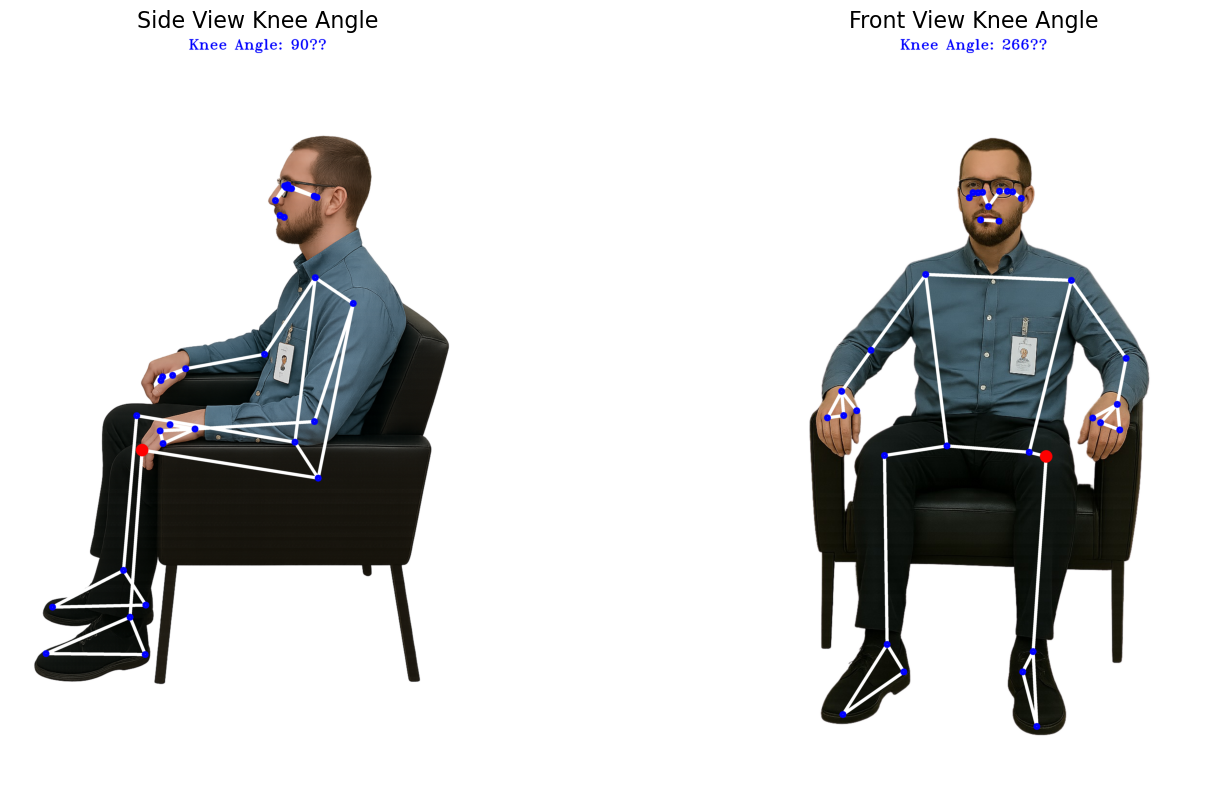

Side view angle:  90.19093465882845
Front view angle: 266.299085294853


In [41]:
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt

# ----------------------------
#  Settings for Text & Drawing
# ----------------------------
FONT            = cv2.FONT_HERSHEY_TRIPLEX
FONT_SCALE      = 3.0
TEXT_COLOR      = (255, 0, 0)   # Blue in BGR
TEXT_THICKNESS  = 4
LINE_TYPE       = cv2.LINE_AA
JOINT_RADIUS    = 12
KNEE_HIGHLIGHT  = 20
SKELETON_WIDTH  = 20

# ----------------------------
#  Initialize MediaPipe Pose
# ----------------------------
mp_pose = mp.solutions.pose
pose    = mp_pose.Pose(static_image_mode=True, model_complexity=2)

# ----------------------------------
#  Helper: compute angle between 3 pts
# ----------------------------------
def calculate_angle(a, b, c):
    """Return the angle (in degrees) at point b formed by points a–b–c."""
    ang = math.degrees(
        math.atan2(c[1] - b[1], c[0] - b[0])
      - math.atan2(a[1] - b[1], a[0] - b[0])
    )
    return ang + 360 if ang < 0 else ang

# --------------------------------------------
#  Main: load image, detect, draw, compute angle
# --------------------------------------------
def get_knee_angle(image_path, ax, title=""):
    # --- load and pad onto white background ---
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading {image_path}")
        return None
    canvas = np.ones_like(img) * 255
    canvas[:img.shape[0], :img.shape[1]] = img
    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

    # --- detect landmarks ---
    result = pose.process(rgb)
    if not result.pose_landmarks:
        print("No landmarks!")
        return None

    lm = result.pose_landmarks.landmark
    # left knee triangle
    hip   = lm[mp_pose.PoseLandmark.LEFT_HIP.value]
    knee  = lm[mp_pose.PoseLandmark.LEFT_KNEE.value]
    ankle = lm[mp_pose.PoseLandmark.LEFT_ANKLE.value]
    angle = calculate_angle((hip.x, hip.y), (knee.x, knee.y), (ankle.x, ankle.y))

    h, w = canvas.shape[:2]

    # --- draw skeleton (white thick) ---
    for (start, end) in mp_pose.POSE_CONNECTIONS:
        p1 = lm[start]; p2 = lm[end]
        x1, y1 = int(p1.x * w), int(p1.y * h)
        x2, y2 = int(p2.x * w), int(p2.y * h)
        cv2.line(canvas, (x1, y1), (x2, y2), (255,255,255), SKELETON_WIDTH)

    # --- draw all joints (blue filled) ---
    for p in lm:
        x, y = int(p.x * w), int(p.y * h)
        cv2.circle(canvas, (x, y), JOINT_RADIUS, (255,0,0), 20)

    # --- highlight the knee joint (red ring) ---
    kx, ky = int(knee.x * w), int(knee.y * h)
    cv2.circle(canvas, (kx, ky), KNEE_HIGHLIGHT, (0,0,255), 40)

    # --- compute & center the angle text at top ---
    txt = f"Knee Angle: {int(angle)}°"
    (tw, th), _ = cv2.getTextSize(txt, FONT, FONT_SCALE, TEXT_THICKNESS)
    tx = (w - tw) // 2
    ty = th + 20  # 20px margin
    cv2.putText(canvas, txt, (tx, ty), FONT, FONT_SCALE, TEXT_COLOR, TEXT_THICKNESS, LINE_TYPE)

    # --- show in Matplotlib ---
    ax.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    return angle

# ----------------------------
#  Plot Side vs. Front
# ----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

side_angle  = get_knee_angle('side_image.png',  ax1, title="Side View Knee Angle")
front_angle = get_knee_angle('front_image.png', ax2, title="Front View Knee Angle")

plt.tight_layout()
plt.show()

print(f"Side view angle:  {side_angle}")
print(f"Front view angle: {front_angle}")
